In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def matprint(mat, fmt="g"):
    """
    Pour une un print plus clair de la matrice
    https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# Table of contents
* [Algorithme non distribué 2 taches 2 classes](#Algorithme-non-distribué-2-taches-2-classes)
     * [1ère étape: Calcul des moyennes empiriques](#1ère-étape)
     * [2ème étape: Estimation de $c$ et de $\mathcal{M}$](#2ème-étape)
     * [3ème étape: Calcul des labels optimaux](#3ème-étape)
     * [4ème étape: Estimation des $m_{tj}$](#4ème-étape)
     * [5ème étape: Calcul de $V$](#5ème-étape)
     * [6ème étape: Evaluation et calcul d'erreur](#6ème-étape)
* [2-class Gaussian mixture transfer](#2-class-Gaussian-mixture-transfer-(c.f.-Figure-2))
* [Adding Tasks](#Adding-tasks)
* [Algorithme distribué 2-tâches 2-classes](#Algorithme-distribué-2-tâches-2-classes)
     * [Serveur isolé](#Serveur-isolé)
* [Distributively adding tasks](#Distributively-adding-tasks)
     * [Working with real data](#Real-Data)
* [Optimalité](#Optimalité)
* [Algorithme distribué k-tâches 2-classes](#Algorithme-distribué-k-tâches-m-classes)
     

Créons des données synthétiques gaussiennes. Ici nous nous intéresserons dans un premier temps au cas où $m=2$. (Binary MTL Supervised Principal Component Analysis) 

# Algorithme non distribué 2 taches 2 classes
Fonctions pour générer des données synthétiques gaussiennes

In [3]:
def mean_matrix(p, beta=None, k=2, m=2,starting=1):
    """
    Crée des vecteurs de moyennes en respectant les conditions de non trivialité 
    retourne un tableau contenant k tableaux de m moyennes.
    beta est le paramètre de task relatedness. Si beta n'est pas précisé, il est tiré au hasard uniformément sur [0,1] pour chaque t.
    k=2, m=2 par défaut
    if starting==1 la premiere moyenne sera les vecteurs canoniques e1 et ep
    """
    mu = np.zeros((p,1))
    mu[0]= 1
    mu_ortho = np.zeros((p,1))
    mu_ortho[2] = 1
    
    M = []
    classes = []
    if starting==1:
        for l in range(m):
            classes.append((-1)**l*mu)
        M.append(classes)
    
    for t in range(starting,k):          
        mu_t = beta*mu+np.sqrt(1-beta**2)*mu_ortho
        classes = []
        for l in range(m):
            classes.append((-1)**l*mu_t)
        M.append(classes)
    return M

In [4]:
def gaussian_synthetic_data(n, p, m, t, n_t, M):
    """
    Renvoie un tableau de données synthétiques gaussiennes. X[0] accède aux données de la premiere tache.
    X[0][1] accede aux données de la deuxieme classe de la premiere tache.
    (vecteurs gaussiens de taille n_j * p tq sum(n_j for j) = n)
    à partir du nombre d'échantillons n de taille p et du nombre de classe m.
    t est le nombre de tâches
    n_t est un vecteur comprenant les différentes valeurs n_j pour chaque task
    M est la matrice des moyennes de chaque composante 
    de chaque vecteur aléatoire
    """
    # assert(sum(n_j)/n==1
    X = []
    tmp = []
    y_test = []
    for task in range(t):
        # pour une tache on a m classes
        tmp = []
        for k in range(m):
#             X_k = np.empty((n_t[task][k], p))
            # on prendra la transposée a la fin
#             print( n_t[task][k])
            mean = np.reshape(M[task][k], p)
#             for j in range(n_t[task][k]):
                # on crée n_j[task][k] vecteurs aléatoires de taille 1xp
            X_k = np.random.multivariate_normal(mean, np.identity(p), size=(n_t[task][k]))
            y_test.append(k)
            X_k = np.transpose(X_k)
            #print(k)
            tmp.append(X_k)
            # print("tmp = ", tmp)
        X.append(tmp)
            
    return X, y_test

## 1ère étape
Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

In [5]:
def empirical_mean(nb_tasks, nb_classes, X, p, n_t, display=False):
    """
    Retourne la matrice M avec les produits scalaires croisés
    cf. Remark 1
    """
    
    M = np.empty((nb_tasks*nb_classes, nb_tasks*nb_classes)) # ici 4x4
    for i in range(nb_tasks):
        for j in range(nb_classes):
            for k in range(nb_tasks):
                for l in range(nb_classes):
                    if i == k and j == l:
                        moitie = int(n_t[i][j]/2)
#                         print("DEBUG diagonal")
#                         print(f"i = {i}, j = {j}")
#                         print(i*nb_classes+j, i*nb_classes+j)
#                         print("moitie : ", moitie)
                        
                        M[i*nb_classes+j][i*nb_classes+j] = np.ones((moitie, 1)).T@X[i][j].T[:moitie]@X[i][j].T[moitie:].T@np.ones((moitie))
                        M[i*nb_classes+j][i*nb_classes+j] /= moitie**2
                    else:
#                         print(i*nb_classes+j, k*nb_classes+l)
#                         print(i, j, k, l)
                        M[i*nb_classes+j][k*nb_classes+l] = np.ones((n_t[i][j], 1)).T@X[i][j].T@X[k][l]@np.ones((n_t[k][l]))
                        M[i*nb_classes+j][k*nb_classes+l] /= n_t[i][j]*n_t[k][l]
    
    if display:
        for t in range(nb_tasks):
            for l in range(nb_classes):
                print(f"class {t*nb_classes+l} empirical mean = {np.mean(M[t*nb_classes+l])}")
                
    return M

In [6]:
def true_mean(M, p, nb_tasks, nb_classes):
    """
    Retourne un ndarray contenant les vraies moyennes avec lequel on peut travailler
    """
    true_M = np.empty((nb_tasks*nb_classes, p))
    for t in range(nb_tasks):
        for l in range(nb_classes):
            mean = np.reshape(M[t][l], (p,))
            true_M[t*nb_classes+l] = mean

    return np.transpose(true_M)

In [7]:
# utile pour les puissances négatives
def power_diagonal_matrix(D, exponent):
    diag = np.zeros(len(D))
    for i in range(len(D)):
        diag[i] = D[i][i]**exponent
    
    return np.diag(diag)

## 2ème étape
Estimer $c$ et $\mathcal{M}\in\mathbb{R}^{2k\times 2k}$. 
$c=\left[ c_{11},\ldots,c_{km} \right]^T\in\mathbb{R}^{km}$

In [8]:
def estimate_c(n_t, n, nb_tasks, nb_classes):
    """
    Estime le vecteur c en divisant n_t[nb_tasks][nb_classes]/n
    """
    c = np.empty(nb_tasks*nb_classes)
    for task in range(nb_tasks):
        for m in range(nb_classes):
            c[task*nb_classes+m]=n_t[task][m]/n
            
    return c

In [9]:
def compute_M_cal(n,p,Dc,MM, k=2, display=False):
    """
    renvoie la matrice M cursive estimée.
    O(2*k)
    """
    c0 = p/n
    correlation_matrix = 1/c0*np.power(Dc, 1/2)@MM@np.power(Dc, 1/2)
    if display==True:
        plt.imshow(correlation_matrix)
        plt.show()
    return correlation_matrix

## 3ème étape
Let's compute optimal labels

In [10]:
# a revoir ?

def label_evaluation(nb_tasks, nb_classes, Dc, M_estimated, c0, task_target=None):
    """
    Evalue le label y pour une tache t pour 2 classes
    task_target=None par défaut, permet de choisir la tâche target en cas d'algo distribué.
    """
    inverse = np.linalg.inv(M_estimated+np.identity(nb_classes*nb_tasks))
    # 0(16*k^3)
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # O(2*k)
    y = np.zeros((nb_tasks*nb_classes, 1))
    e3_e4 = np.zeros((nb_tasks*nb_classes,1))
    if task_target is not None:
        e3_e4[2*task_target] = 1
        e3_e4[2*task_target+1] = -1
    else:
        e3_e4[-2] = 1
        e3_e4[-1] = -1
    tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    # O(8*k^3)
    return tilde_y
#malik's formula:
#tilde_y=(diag(c)*MM*diag(c)/co+diag(c))\((e3-e4)'*MM*diag(c))';

## 4ème étape
Estimation des $m_{tj}$, étant les $k\times m$ moyennes estimées pour modéliser nos données.

In [11]:
def asymptotic_mean(nb_tasks, nb_classes, y_tilde, Dc, correlation_matrix, t, j, c0=1/21):
    """
    compute asymptotic mean m_tj
    t current task
    j current class
    """
    y_transpose = np.transpose(y_tilde)
    etj = np.zeros((nb_tasks*nb_classes, 1))
    etj[t*nb_classes+j] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    # Dc^1/2 ou Dc^{-1/2} ?
    m_tj = np.sqrt(c0)*y_transpose.dot(np.power(Dc, 1/2)).dot(correlation_matrix).dot(power_dc).dot(etj)
    m_tj /= np.sqrt(y_transpose.dot(np.power(Dc, 1/2).dot(correlation_matrix).dot(np.power(Dc, 1/2)) + Dc).dot(y_tilde))
    return m_tj[0][0]

## 5ème étape
Calcul de $V$ le sous-espace engendrés par les $\tau$ plus grands vecteurs propres. Dans le cas du binary MTL-SPCA, $V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}\in\mathbb{R}^{p\times1}$, avec $J\in\mathbb{R}^{n\times km}$

In [12]:
def aggregate_array(X, p, n, nb_tasks, nb_classes):
    X_aggregated = np.empty((p, n))
    class_1 = X[0][0]
    for t in range(nb_tasks):
        for l in range(nb_classes):
            if t==0 and l==0:
                continue
            class_1 = np.append(class_1, X[t][l], 1)
    X_aggregated = class_1
    return X_aggregated

$V=\frac{Xy}{\lVert Xy \rVert}=\frac{XJ\tilde{y}}{\lVert XJ\tilde{y} \rVert}$

In [13]:
def create_J(nb_classes, nb_tasks, n, n_t):
    # enlever paramètre n
    left = 0
    beg = 0
    for i in range(nb_tasks):
        left += int(sum(n_t[i]))
    J = np.zeros((left, nb_tasks*nb_classes))
    #matprint(J)
    for t in range(nb_tasks):
        for j in range(nb_classes):
            for i in range(beg, beg+n_t[t][j]):
                J[i][t*nb_classes+j] = 1
            beg += n_t[t][j]
    return J

In [14]:
def compute_V_old(y_tilde, X, J):
    """
    Utilise la formule explicite de V pour la classification binaire
    """
    xy_product = X.dot(J).dot(y_tilde)
    return xy_product/np.linalg.norm(xy_product)

def compute_V(y, X, J, n):
    """
    Recalcule V (calcul vecteur propre)
    Vstar dans le fichier matlab
    Division par p, si les X pas normalisé ?
    wtf is wrong with V? 
    """
    #X*J*(tilde_y*tilde_y')*J'*X'/n
    #print(X.shape)
    eigenvalue, V = np.linalg.eig(X.dot(J).dot((y).dot(y.T)).dot(J.T).dot(X.T)/(n))
    maximum = eigenvalue[0]
    idx_larg = 0
    # retrieve the index of the largest eigenvalue
    for idx, value in enumerate(eigenvalue):
        if value > maximum:
            maximum = value
            idx_larg = idx
    
    largest_eigenvalue = np.sort(eigenvalue.real)[-1]
    return V.T[idx_larg].real

## 6ème étape
Evaluation de nouvelles données $\mathbf{x}$ : 
$V^T\mathbf{x}$

On utilise les données du test set $X\_test$. On obtient de très mauvais résultats

In [15]:
def create_mt(t, m, y, Dc, correlation_matrix, c0):
    m_t = []
    for k in range(t):
        m_tj = []
        for l in range(m):
            m_tj.append(asymptotic_mean(t, m, y, Dc, correlation_matrix, k, l, c0))
        m_t.append(m_tj)

    return m_t

In [16]:
def compute_score(V, x, m_t, rho1=0.5, rho2=0.5, average=True):
    """
    x vecteur aléatoire que l'on veut classifier
    On compare V^Tx à la moyenne des moyennes estimées pour les deux classes de la tache t
    """
    x_projection = np.transpose(V).dot(x)
#     print(f"m_t[0], m_t[1] = {m_t[0]}, {m_t[1]}")
    if average:
        average_mean = 1/2*(m_t[0] + m_t[1]) - 1/(m_t[0]-m_t[1])*np.log(rho1/rho2)
    else:
        average_mean = 0
#     print(f"avg : {average_mean}")
    return (1 if x_projection > average_mean else -1) 

In [17]:
from scipy import special as sp
def qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

In [18]:
def error_rate(nb_tasks, nb_classes, Dc, M_cur, c0, task_target=1):
    e3 = np.zeros((nb_tasks*nb_classes, 1))
    e3[2*task_target] = 1
    power_dc = power_diagonal_matrix(Dc, -1/2)
    inv = np.linalg.inv(M_cur+np.identity(nb_tasks*nb_classes))
    print("arg q-func : ")
    print(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3))
    return qfunc(np.sqrt(e3.T.dot(M_cur).dot(Dc).dot(np.linalg.inv(Dc.dot(M_cur).dot(Dc)+c0*Dc)).dot(Dc).dot(M_cur).dot(e3)))
    #return qfunc(1/2*np.sqrt(et_trans.dot(power_dc).dot(M_cur).dot(inv).dot(M_cur).dot(power_dc).dot(et1_et2)))
#erfc(sqrt(e3'*MM*diag(c)*inv((diag(c)*MM*diag(c)+diag(co*c/k)))*diag(c)*MM*e3)/(sqrt(2)))/2;

In [19]:
def plot_error_rate(nb_tasks, nb_classes, emp_rate, error_rate, m_t, Dc, M_cur):
    plt.scatter(1, emp_rate, label="empirical error")
    plt.scatter(1, [error_rate(m_t[1], nb_tasks, nb_classes, Dc, M_cur)], label="theoritical error")
    plt.grid()
    plt.ylim((0,1))
    plt.xlim((-0.5, 0.5))
    plt.legend()
    plt.title(f"Classification error rate per task")
    plt.show()

In [20]:
def compute_error_rate(X_test, V, m_t, nb_classes, n_t, Dc, c0, task_target=1, rho1=0.5, rho2=0.5, debug=False, average=True):
    """
    Compute and plot classification error rate on test set
    """
#     print("mt1= \n", m_t[1])
    error = 0
    eps1,eps2=0,0
    ni = sum(n_t[0])
    for l in range(nb_classes):
        for i in range(n_t[0][l]):
            # on prend la transposée pour pouvoir travailler avec les colonnes
            
            score = compute_score(V, X_test[0][l].T[i].T, m_t[task_target], rho1, rho2, average)
            # misclassifaction of class 1 in class 2, 
            if (score == -1 and l == 0):
                error +=1
                eps1+=1
            #missclassification of class 2 in class 1
            elif (score == 1 and l == 1):
                error +=1
                eps2+=1
                    
    erreur_emp = error/ni
    
    if erreur_emp > 0.5:
        erreur_emp=1-erreur_emp
#     emp_rate.append(erreur_emp)
    print("Epsilon 1 et 2 : ")
    if debug:
        print(eps1/n_t[0][0])
        print(eps2/n_t[0][1])
        print(erreur_emp)
        print(eps1/n_t[0][0]*rho1+eps2/n_t[0][1]*rho2)
        eps1=eps1/n_t[0][0]
        eps2=eps2/n_t[0][1]
        if eps1>0.5:
            eps1=1-eps1
        if eps2>0.5:
            eps2=1-eps2
        print(f"erreur empirirque = {erreur_emp}")
        return erreur_emp, eps1, eps2
    return erreur_emp

In [21]:
def debug_histogram(V, X_test, n_t):
    """
    Trace l'histogramme de V^T*x_1 et V^T*x_2.
    """
#     print(X1[0][0])
#     print(n_t[0][0])
    alpha = 0.5
    bins = 20
    plt.hist(V.T.dot(X_test.T[:n_t[0][0]].T), bins = bins, alpha=alpha, label=r"$C_1$", density=True)
    plt.hist(V.T.dot(X_test.T[n_t[0][0]:].T), bins = bins, alpha=alpha, label=r"$C_2$", density=True)
    plt.grid()
    plt.title(r"Histogramme des données de tests projetées sur $V$ : $V^Tx_j$")
    plt.legend()
    plt.show()

# 2-class Gaussian mixture transfer (c.f. Figure 2)

In [22]:
from time import time
from scipy.stats import norm 
plt.style.use('seaborn-dark-palette')

In [23]:
def optimal_rate(xx, rho1, rho2):
    """
    Renvoie l'optimum bayésien.
    """
    return 1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2)))

In [24]:
#%%prun -s cumulative
# profiling
%matplotlib inline
p = 100
m = 2
t = 2
beta = np.linspace(0,1,10)
# n_t = [[50, 50], [10, 10]]
n_t = [[80, 20], [80, 20]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
# n_t_test = [[1000, 1000]]
n_t_test = [[50, 50]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []

temps_MM = []
temps_estim = []
temps_inference = []
moyennes = []
e1, e2 = [], []
R1, R2 = [], []
for idx, b in enumerate(beta):
    print(f"beta = {b}")
    M = mean_matrix(p, b, t)
    c = estimate_c(n_t, n, t, m)
    #     print("c : ")
    #     print(c)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    
    # erreur théorique optimale
    moyennes.append(optimal_rate(xx, rho1, rho2))
# #     err = []
# #     epsilon1, epsilon2 = [], []
#     for l in range(10):
#         X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M)
#         X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[1]])

#         MM = empirical_mean(t, m, X, p, n_t)
#         print("MM : \n")
#         correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
    #     matprint(correlation_matrix)
#         y = label_evaluation(t,m,Dc,MM, c0)
    #     print("correlation matrix true : ")
    #     matprint(correlation_matrix_true)
    #     print("c0 : ", c0)
    #     diff = np.abs(correlation_matrix-correlation_matrix_true)
    #     print("erreur relative M cursive")
    #     matprint(diff/np.abs(correlation_matrix_true))
#         
#         X_train_aggregated = aggregate_array(X, p, n, t, m)
#         X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)

#         J = create_J(m, t, n, n_t)
#         V = compute_V_old(y, X_train_aggregated, J)
#         V = np.reshape(V, p)
#         V_true = compute_V_old(y_true, X_train_aggregated, J)
#         V_true = np.reshape(V_true, p)

#         m_t = create_mt(t, m, y, Dc, correlation_matrix, c0)
#         print(f"m_t = {1/2*(m_t[1][0]+m_t[1][1])}")
        
#         print(f"rho1, rho2 = {rho1}, {rho2}")
#         erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
        
#         err.append(erreur_empirique)
#         epsilon1.append(eps1)
#         epsilon2.append(eps2)
        
#     x = np.linspace(-3,3, 500)
#     plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
#     plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     emp_rate.append(np.mean(err))
#     e1.append(np.mean(epsilon1))
#     e2.append(np.mean(epsilon2))
#     var.append(np.std(err))
    
%matplotlib qt
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, moyennes, '-^', label='erreur optimal')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()


beta = 0.0
beta = 0.1111111111111111
beta = 0.2222222222222222
beta = 0.3333333333333333
beta = 0.4444444444444444
beta = 0.5555555555555556
beta = 0.6666666666666666
beta = 0.7777777777777777
beta = 0.8888888888888888
beta = 1.0


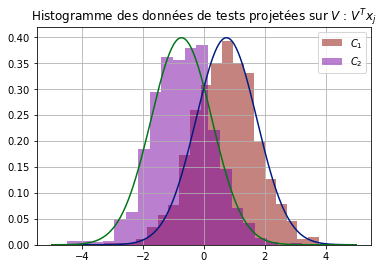

(100,)
(100, 2000)
-0.3208736574474463
0.7591086580652291
qfunc((m1-m2)/2) = 0.705398434812235
0.30369999999999997
xx =  -1.0799823155126753
m1 =  -0.3208736574474463
m2 =  0.7591086580652291
eps
0.25
qfuncs
0.7338745433285422
0.6755923662008608
0.6285999999999999 0.6573
e1, e2, e3, e4 = 0.30369999999999997, 0.35705, 0.2952665452352985, 0.29460156518776504
[]


In [28]:
%matplotlib inline
x = np.linspace(-5,5, 500)
plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
debug_histogram(V, X_test_aggregated, n_t_test)
emp_rate.append(np.mean(err))
var.append(np.std(err))
print(V.shape)
print(X_test_aggregated.shape)
m2 = np.mean(V.T@X_test_aggregated.T[:400].T)
m1 = np.mean(V.T@X_test_aggregated.T[600:].T)
print(m1)
print(m2)
print(f"qfunc((m1-m2)/2) = {qfunc((m1-m2)/2)}")
print(np.mean(err))
xx = m1-m2
print("xx = ", xx)
print("m1 = ", m1)
print("m2 = ", m2)
#print(1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2))))
e4 = 1-(rho1*qfunc(xx/2+1/xx*np.log(rho1/rho2))+rho2*qfunc(xx/2-1/xx*np.log(rho1/rho2)))
print("eps")
print(rho1*0.15+rho2*0.35)
print("qfuncs")
print(1-qfunc(np.mean(err)-m1))
print(qfunc(np.mean(err)-m2))
print(1-e1[0], 1-e2[0])
e3 = 1-(rho1*qfunc(m1-np.mean(err))+rho2*qfunc(np.mean(err)-m2))
print(f"e1, e2, e3, e4 = {np.mean(err)}, {(rho1*e1[0]+rho2*e2[0])}, {e3}, {e4}")
print(th_rate)

In [60]:
# x = np.linspace(-10,10, 500)
m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
print(m_t_true[1][0])
# plt.plot(x, 1*norm.pdf(x, m_t[1][0], 1))
# plt.plot(x, 1*norm.pdf(x, m_t[1][1], 1))
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
print(m_t)
print(qfunc(1/2*(m_t_true[1][1]-m_t_true[1][0])))
plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.plot(beta, th_rate, '-v', label='theoritical rate')
# plt.plot(beta, R2, '-^', label='optimal rate')
plt.plot(beta, moyennes, '-^', label='optimal rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.scatter(0, lower[0], 'o', label='std-low')
# plt.scatter(0, upper[0], 'o', label='std-up')
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

0.7071067811865475
[[0.03809653410913311, -0.033077735382288934], [0.8224336201687215, -0.8181541254818973]]
0.7602499389065233


In [41]:
from datetime import datetime
now = datetime.now()
date = now.strftime("%Y-%m-%d %H:%M:%S")
with open("log.txt", "a") as log:
    log.write(f"Courbe pour added tasks (D) tracé le {date}\n\nEmpirique:\n\n")
    for i,j in enumerate(t):
        log.write(f"({j}, {emp_rate[i]})")
    log.write("\n\nThéorique:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {th_rate[i]})")
    log.write("\n\nLower:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {lower[i]})")
    log.write("\n\nUpper:\n\n")
    for i,j in enumerate(t): 
        log.write(f"({j}, {upper[i]})")    
        
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent[i]})")
#     for i,j in enumerate(t): 
#         log.write(f"({j}, {data_sent_nd[i]})")
    log.write("\n-----------------\n")

In [68]:
# erreur_relative_prec = 0.054
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations et {nt} données de test : {round(erreur_relative_moy, 3)}")

# print(f"En doublant n et p proportionnellement, l'erreur relative moyenne est divisé par un facteur {(1/(erreur_relative_prec/erreur_relative_moy))}")


# print(f"Temps moyen pour (resp.) le calcul des produits scalaires entre moyennes empiriques, l'estimation de M cursive, c et les labels optimaux y, et l'inférence : {round(np.mean(temps_MM), 5)} s, {round(np.mean(temps_estim), 5)} s, {round(np.mean(temps_inference), 5)} s.\nLe temps total moyen est ainsi de {round(np.mean(temps_estim) + np.mean(temps_MM) , 5)} s")

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.plot(beta, moyennes, '-^', label='optimal rate')
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Adding tasks

In [34]:
# %%prun -s cumulative
# profiling
%matplotlib inline
p = 100
m = 2
# on ajoute des tâches 2 par 2
nb_tasks = 20
t = list(range(2,2*nb_tasks, 2))
to_add = [100, 100], [20, 20]
n_t = []
n_t_test = [[500, 500]]
nt = sum(n_t_test[0])
# la liste temps comprendra le temps pour le training, le calcul de M et y et le temps d'inférence
emp_rate, th_rate, var, relative_error_rate = [], [], [], []
task_target = 1

betat = np.random.uniform(low=0.4, high=0.8, size=(len(2*t)))
# betat = [0.29405,
#    0.40548,
#    0.37921,
#    0.38012]  

beta = 0
X = []
X_test = []
M = []
# on choisit des données de test
print(f"beta = {betat[task_target]}")
mean = mean_matrix(p, beta=betat[task_target], k=2)
M.append(mean[0])
M.append(mean[1])
# print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")
# X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
# X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
# vec1 = np.zeros((p,1))
# vec1[0] = 1

# M_true= np.concatenate((vec1, -vec1), axis=1)
# M_true= np.append(M_true, np.concatenate((vec2, -vec2), axis=1), axis=1)
# vec2, vec3,vec4, vec5 = np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1)), np.zeros((p,1))
# vec2[0], vec2[1] = 0.29405, 0.95579
# vec3[0], vec3[1] = 0.40548, 0.91410
# vec4[0], vec4[1] = 0.37921, 0.92531
# vec5[0], vec5[1] = 0.40548, 0.91410

n=0
for b in (t):
    print(b)
#     err=[]
    n_t.append(to_add[0])
    n_t.append(to_add[1])
#     if b==4:
#         M_true= np.append(M_true, np.concatenate((vec3, -vec3), axis=1), axis=1)
#         M_true= np.append(M_true, np.concatenate((vec4, -vec4), axis=1), axis=1)
#     elif b==6:
#         M_true= np.append(M_true, np.concatenate((vec5, -vec5), axis=1), axis=1)
#         M_true= np.append(M_true, np.concatenate((vec4, -vec4), axis=1), axis=1)
        
        
#     print(b)
#     print(n_t)
    n += sum(to_add[0])+sum(to_add[1])
#     print(n)
    # on crée les données synthétiques 
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc,MM_true, c0, 1)
    matprint(y_true)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    J = create_J(m, b, n, n_t)
    for l in range(5):
        for i in range(2):
#             print(f"beta = {betat[beta]}")
            mean = mean_matrix(p, beta=betat[beta], k=1, starting=0)
            M.append(mean[0])
#             print(f"Verif beta = {M[b-2+i][0][0]}, {M[b-2+i][0][1]}")
#             print(f"Generating synth data with M[{beta}]")

#             synth = gaussian_synthetic_data(sum(to_add[i]), p, m, 1, [n_t[i]], [M[beta]])[0]
#             if l==0:
#                 X.append(synth[0][:])
#             else:
#                 X[b-2+i] = synth[0][:]
            beta+=1
        beta-=2
    #     print(M)
#         print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")

    # DEBUG
        #MM1, diag1 = empirical_mean_old(1, m, X, p, [n_t[0]])
        # On calcule les moyennes empiriques
#         MM = empirical_mean(b, m, X, p, n_t, True)
#         correlation_matrix = compute_M_cal(n, p, Dc, MM, display=False)
#         y = label_evaluation(b,m,Dc,MM, c0, task_target=task_target)
        
#         X_train_aggregated = aggregate_array(X, p, n, b, m)
#         V = compute_V(y, X_train_aggregated, J, n)
#         V_true = compute_V(y_true, X_train_aggregated, J, n)
#         m_t = create_mt(b, m, y, Dc, correlation_matrix, c0)
#         erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
#         err.append(erreur_empirique)
#     beta+=2
    # On time le temps d'inférence 
    
#     x = np.linspace(-3,3, 500)
#     plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
#     plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
#     debug_histogram(V_true, X_test_aggregated, n_t_test)
#     print("V = ")
#     VTX = V.T@X_test_aggregated
#     debug_histogram(V, X_test_aggregated, n_t_test)
#     var.append(np.var(VTX))
    print(rho1, rho2)
    erreur_th = optimal_rate(xx, rho1, rho2)
#     emp_rate.append(np.mean(err))
#     var.append(np.std(err))
    th_rate.append(erreur_th)
#     relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)
    
# erreur_relative_moy = np.mean(relative_error_rate)
# print(f"Erreur relative moyenne pour n={n} et p={p}, moyennée sur 10 simulations")


%matplotlib qt
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(t, emp_rate, '-o', label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
# plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

beta = 0.5822900567962275
2
 0.71142  
-0.71142  
 2.83678  
-2.83678  
0.5 0.5
4
 0.328483  
-0.328483  
   2.6498  
  -2.6498  
   2.2751  
  -2.2751  
   2.6498  
  -2.6498  
0.5 0.5
6
 0.0163295  
-0.0163295  
   2.64472  
  -2.64472  
   2.18992  
  -2.18992  
   2.64472  
  -2.64472  
   2.18992  
  -2.18992  
   2.64472  
  -2.64472  
0.5 0.5
8
-0.277248  
 0.277248  
  2.67822  
 -2.67822  
  2.14143  
 -2.14143  
  2.67822  
 -2.67822  
  2.14143  
 -2.14143  
  2.67822  
 -2.67822  
  2.14143  
 -2.14143  
  2.67822  
 -2.67822  
0.5 0.5
10
-0.561285  
 0.561285  
  2.72569  
 -2.72569  
  2.10697  
 -2.10697  
  2.72569  
 -2.72569  
  2.10697  
 -2.10697  
  2.72569  
 -2.72569  
  2.10697  
 -2.10697  
  2.72569  
 -2.72569  
  2.10697  
 -2.10697  
  2.72569  
 -2.72569  
0.5 0.5
12
-0.838678  
 0.838678  
  2.77946  
 -2.77946  
  2.07944  
 -2.07944  
  2.77946  
 -2.77946  
  2.07944  
 -2.07944  
  2.77946  
 -2.77946  
  2.07944  
 -2.07944  
  2.77946  
 -2.77946  


0.5 0.5


In [118]:
print(M_true.shape)
print(Dc.shape)
print(y_true)
print(M_true[:1])

(100, 8)
(8, 8)
[[-0.08458442]
 [ 0.08458442]
 [ 4.01853101]
 [-4.01853101]
 [ 3.66970556]
 [-3.66970556]
 [ 4.01853101]
 [-4.01853101]]
[[ 1.         -1.          0.73116226 -0.73116226  0.78095511 -0.78095511
   0.73116226 -0.73116226]]


In [49]:
print(X_test_aggregated.shape)
for i in range(0, len(M)):
    print("new task")
    for j in range(2):
        print(M[i][j][0])
matprint(M_true.T@M_true)
print(n_t)

(2000, 200)
new task
[1.]
[-1.]
new task
[0.02592623]
[-0.02592623]
new task
[0.4359949]
[-0.4359949]
new task
[0.02592623]
[-0.02592623]
         1          -1   0.0259262  -0.0259262  
        -1           1  -0.0259262   0.0259262  
 0.0259262  -0.0259262           1          -1  
-0.0259262   0.0259262          -1           1  
[[50, 50], [6, 6]]


In [56]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(range(len(emp_rate)), emp_rate, '-o', label='empirical rate')
plt.plot(range(len(emp_rate)), th_rate, '-o', label='theoritical rate')
plt.fill_between(range(len(emp_rate)), lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title("2-class Gaussian mixture transfer error rate")
plt.xlabel("Added Task")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Algorithme distribué k tâches 2 classes
Bien que certains résultats du précedent algorithmes sont particulèrement inquiétants, essayons de voir comment distribuer l'algorithme sur plusieurs serveurs.

Par exemple un serveur demande les moyennes des autres serveurs pour pouvoir obtenir des meilleurs résultats en calculant la moyenne des ses données et la moyenne de toutes les moyennes avant de le renvoyer au serveur principal qui mettra à jour le modèle.

Prendre des données synthétiques pour la 1ère tâche à 2 classes, puis rappatrier une ou plusieurs moyennes pour les autres tasks. 
Faire des comparaisons, avec et sans federated learning.

### k serveurs 
#### Federated Learning 2 classes k taches
Imaginons 1 Serveur central et k clients. L'un cherche à classifier un certain type d'images, l'autre un deuxième type d'images. Les deux clients sont confrontés un problème de classification binaire sur des images sensiblement similaire (quantifié par le paramètre $\beta$), et peuvent donc s'aider du training de l'autre pour affiner leur classification.

Le premier client entraîne son modèle de classification sur son jeu de données locales. Il espère obtenir de meilleures performances à l'aide du transfer Learning. Les deux clients envoient alors les moyennes empiriques calculées sur leurs donnée locales, au serveur central. Le serveur peut alors calculé la matrice de corrélation $\mathcal{M}$ et les labels optimaux $\tilde{y}$. Les clients recoivent les labels optimaux, et peuvent maintenant recalculer le vecteur propre $V$ de $\displaystyle\frac{X_ty_ty_t^TX_t^T}{np}$ et inférer sur de nouvelles données $x$.

Calcul des moyennes empiriques, et calcul de la matrice $M\in\mathbb{R}^{p\times 2k}$
$$\frac{1}{n_{tj}}X_{tj}\mathbb{1}_{n_{tj}}=\frac{1}{n_{tj}}\sum_{l=1}^{n_{tj}}x_{tl}^{(j)}$$

Chaque client calcule en local les moyennes empiriques des données et les envoie au serveur central.

De la même façcon que précédemment les données de chaque client (=chaque tâche) devront respecter les conditions de non-trivialité.

In [114]:
def empirical_mean_old(nb_tasks, nb_classes, X, p, n_t):
    """
    compute empirical mean for data 
    retourne la matrice M de taille px(2*k) et un vecteur contenant les coefficients diagonaux
    nb_classes=2 (toujours)
    
    Complexité : 
    -------------
    O(k*p*n_tl) = O(n*p)
    """
    M = np.empty((nb_classes*nb_tasks, p))
    diag = []
    for t in range(nb_tasks):
        # O(k)
        for l in range(nb_classes):
            # O(2)
            M[t*nb_classes+l] = X[t][l].dot(np.ones((n_t[t][l])))
            # O(p*n_tl)
            M[t*nb_classes+l] /= n_t[t][l]
            # O(1)
            
            moitie = int(n_t[t][l]/2)
#             print(f" moitie = {moitie}")
#             print("shape X : ", X[t][l].T[:moitie].T.shape)
            mu1 = X[t][l].T[:moitie].T@np.ones((moitie))
            mu2 = X[t][l].T[moitie:].T@np.ones((moitie))
#             print("mu shapes before : ")
#             print(mu1.shape)
#             print(mu2.shape)
            # O(p*n_tl)
            mu1, mu2 = np.reshape(mu1, (p, 1)), np.reshape(mu2, (p, 1))
#             print("mu shapes : ")
#             print(mu1.shape)
#             print(mu2.shape)
            diag.append(mu1.T@mu2/moitie**2)
            # O(1)
    return M.T, diag

# diag1 = [mu1]
#diag_means = [[mu1], [mu2]]

def gather_empirical_mean(nb_tasks, nb_classes, emp_means, diag_means, p, n_t):
    """
    emp_means est un vecteur contenant les moyennes empiriques de chaque tache de chaque classe.
    Chaque vecteur de moyennes et de taille px1
    Renvoie la matrice M des, produits scalaires entre moyennes empiriques de chaque client
    """
    M = np.empty((nb_classes*nb_tasks, nb_classes*nb_tasks)) # ici 4x4
    for i in range(nb_tasks):
        # O(k)
        for j in range(nb_classes):
            # O(2)
            for k in range(nb_tasks):
                # O(k)
                for l in range(nb_classes):
                    # O(2)
                    if i == k and j == l:
                        #print(f"i = {i}, j = {j}")
                        #print(i*nb_classes+j, i*nb_classes+j)
#                         print(moitie)
#                         print(np.ones((moitie, 1)).T.dot(X[i][j].T[:moitie]).shape)
#                         print(emp_means[i*nb_tasks+j][:moitie].T.shape)
                        M[i*nb_classes+j][i*nb_classes+j] = diag_means[i*nb_classes+j]
                    else:
                        #print(i*nb_classes+j, k*nb_classes+l)
#                         print(emp_means[i*nb_tasks+j].T.shape)
#                         print(emp_means[k*nb_tasks+l].shape)
                        M[i*nb_classes+j][k*nb_classes+l] = emp_means[i*nb_classes+j].T@emp_means[k*nb_classes+l]
                    # O(p)
#                         print(M[i*nb_tasks+j][k*nb_tasks+l].shape)
                
    return M

In [117]:
def merging_center(MM, diag, t, m, p, n, n_t, task_target=None, display=False, normalization=False):
    """
    Recoit les moyennes empiriques des k clients, calcule la matrice de corrélation, les labels optimaux et renvoie le vecteur V
    Renvoie y un vecteur de labels optimaux adapté à chaque client. (à changer?)
    """
    # MM = [[MM11, MM12], [MM21, MM22], [MM31, MM32], ...]
    emp_means = []
    diagonal = []
    
    for i in range(len(MM)):
        for l in range(m):
            emp_means.append(np.reshape(MM[i].T[l], (p, 1)))
            diagonal.append(diag[i][l])
    #diag = [diag1[0], diag1[1], etc.]
    #emp_means = [MM11, MM12, MM21, MM22, MM31, ...]
    MM_gathered = gather_empirical_mean(t, m, emp_means, diagonal, p, n_t)
    if normalization:
        MM_gathered /= np.linalg.norm(MM_gathered)
    if display:
        print("MM_gathered : ")
        matprint(MM_gathered)
    
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
    correlation_matrix = compute_M_cal(n, p, Dc, MM_gathered, display=display)
    y = label_evaluation(t,m,Dc,MM_gathered, c0, task_target=task_target)
#     e3=np.zeros((m*t,1));e3[-2]=1;
#     e4=np.zeros((m*t,1));e4[-1]=1;
#     y = np.linalg.solve((np.diag(c)+np.diag(c)@MM_gathered@np.diag(c/c0)),(np.diag(c/c0)@MM_gathered@(e3-e4)))
#     tilde_y=np.linalg.solve((Dc+Dc@M_estimated@Dc*1/c0),(Dc*1/c0@M_estimated@(e3_e4)))
    if display:
        print("y : ")
        matprint(y)
    
    # le serveur calcule aussi V
    V = np.zeros((p,1))
    for i in range(t):
        for j in range(m):
            V += n_t[i][j]*emp_means[i*m+j]*y[i*m+j]
    V /= np.linalg.norm(V)
    V = np.reshape(V, (p))
    
    return V, y, correlation_matrix, Dc, c0

rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.4706
0.06055
0.14256
0.14256000000000002
erreur empirirque = 0.14256
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.4818
0.04815
0.13488
0.13488
erreur empirirque = 0.13488


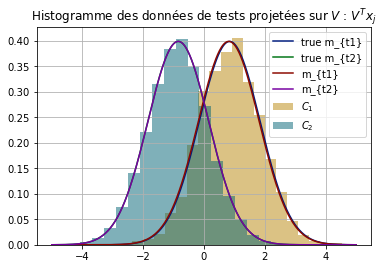

[0.13872] [0.1363459850337876]
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.4574
0.0581
0.13796
0.13796
erreur empirirque = 0.13796
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.5092
0.04675
0.13924
0.13924
erreur empirirque = 0.13924


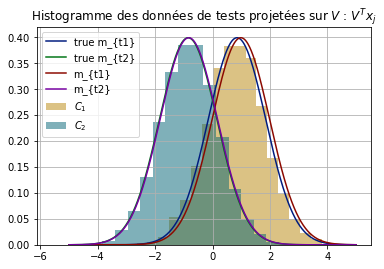

[0.13872, 0.1386] [0.1363459850337876, 0.13546705786891344]
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.4974
0.04575
0.13608
0.13608
erreur empirirque = 0.13608
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.483
0.04215
0.13032
0.13032
erreur empirirque = 0.13032


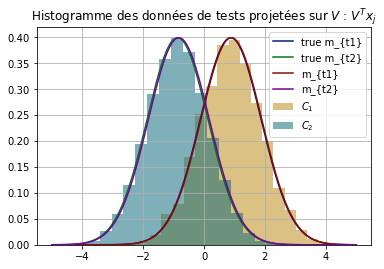

[0.13872, 0.1386, 0.13319999999999999] [0.1363459850337876, 0.13546705786891344, 0.13175563023572434]
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.4134
0.041
0.11548
0.11548
erreur empirirque = 0.11548
rho1, rho2 = 0.2, 0.8 in function
rho1, rho2 = 0.2, 0.8 in function
Epsilon 1 et 2 : 
0.3886
0.04985
0.1176
0.11760000000000001
erreur empirirque = 0.1176


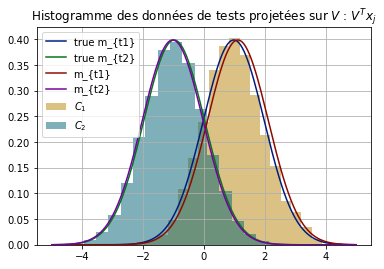

[0.13872, 0.1386, 0.13319999999999999, 0.11654] [0.1363459850337876, 0.13546705786891344, 0.13175563023572434, 0.11535857903206181]


In [26]:
%matplotlib inline
n1 = 2000
n2 = 100
n = n1+n2
p = 100
m = 2
t = 2
ni = [n1, n2]
beta = np.linspace(0,1,4)
n_t = [[1000,1000], [50, 200]]
n_t_test = [[5000, 20000]]
nt = sum(n_t_test[0])
emp_rate, th_rate, var = [], [], []

task_target = 1
for b in beta:
    err = []
    # on crée les données synthétiques
    M = mean_matrix(p, b, t)
    c = estimate_c(n_t, n, t, m)
    c0 = p/n
    Dc = np.diag(c)
    M_true = true_mean(M, p, t, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(t,m,Dc,MM_true, c0)
    m_t_true = create_mt(t, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    # erreur théorique optimale
    th_rate.append(optimal_rate(xx, rho1, rho2))
    for l in range(2):
        X, y_bs = gaussian_synthetic_data(n, p, m, t, n_t, M)
        X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
        MM = []
        diag = []        
        # On calcule les moyennes empiriques sur les données locales
        # diag1 = [diag1[0], diag1[1]]
        for i in range(t):
            MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
            MM.append(MM1)
            diag.append(diag1)

    # CENTRAL SERVER
        # sending empirical means to central server
        # y est un vecteur de vecteurs de labels optimaux
        V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, normalization=False)

    # END CENTRAL SERVER

        # Sending back optimal labels to clients
#         aggregated = []
#         for i in range(t):
#             aggregated.append(aggregate_array([X[i]], p, ni[i], 1, m))
        m_t = create_mt(t, m, y, Dc, correlation_matrix, c0)
        X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
        erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True)
        err.append(erreur_empirique)
#         epsilon1.append(eps1)
#         epsilon2.append(eps2)
        
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t_true[1][0], 1), label=r"true m_{t1}")
    plt.plot(x, norm.pdf(x, m_t_true[1][1], 1), label=r"true m_{t2}")
    plt.plot(x, norm.pdf(x, m_t[1][0], 1), label=r"m_{t1}")
    plt.plot(x, norm.pdf(x, m_t[1][1], 1), label=r"m_{t2}")    
    debug_histogram(V, X_test_aggregated, n_t_test)
    emp_rate.append(np.mean(err))
#     e1.append(np.mean(epsilon1))
#     e2.append(np.mean(epsilon2))
    var.append(np.std(err))
    print(emp_rate, th_rate)

%matplotlib qt

lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-v', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

In [79]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.plot(beta, emp_rate, '-o', label='empirical rate')
plt.plot(beta, th_rate, '-o', label='theoritical rate')
plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
plt.legend()
plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
plt.xlabel("Task relatedness (beta)")
plt.ylabel("error rate")
plt.grid()
plt.show()

# Distributively adding tasks

In [ ]:
#%%prun -s cumulative
%matplotlib inline
# profiling
p = 200
m = 2

# t = [7]
# t = list(range(2,3))
t = [2**i for i in range(2,6)]
n_t_test = [[10000, 10000]]
nt = sum(n_t_test[0])

# np.random.seed(1)
emp_rate, th_rate, var, relative_error_rate = [], [], [], []
task_target = 1
betat = np.random.uniform(0.5,1,size=(t[-1]))
# betat = 0.2*np.ones((t[-1]))
beta = 0
X = []
X_test = []
M = []
n_t = []
n=0
# print(f"beta = {betat[task_target]}")
mean = mean_matrix(p, beta=betat[task_target], k=2)
M.append(mean[0])
moy = mean[1][:]
# print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [moy])
X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)

added=False
for idx,b in enumerate(t):
    if idx==0:
        boucle= b
    else:
        boucle = b-t[idx-1]
    print(f"boucle = {boucle}")
    to_add = [50, 50]
    for i in range(boucle):
#         print(f"beta = {betat[beta]}")
        mean = mean_matrix(p, beta=betat[beta], k=1, starting=0)
        if i==task_target and not added:
            M.append(moy)
            n_t.append([6,6])
            added=True
        else:
            n_t.append(to_add)
            M.append(mean[0])
        beta+=1
    err=[]
    print(b)
    n=0
    print(n_t)
    for i in range(len(n_t)):
        n += sum(n_t[i])
    print("n = ", n)
    # on crée les données synthétiques 
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    print("c0 : ",c0)
    Dc = np.diag(c)
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc,MM_true, c0, 1)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[task_target][1]-m_t_true[task_target][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    J = create_J(m, b, n, n_t)
    for l in range(1):
        X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M)
        MM = []
        diag = []

        for i in range(b):
            MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
#             print(f"task 1 empirical mean = {np.mean(MM1[0])}")
            MM.append(MM1)
            diag.append(diag1)
        V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, b, m, p, n, n_t, task_target, False, normalization=False) 
        X_train_aggregated = aggregate_array(X, p, n, b, m)
#         MM = empirical_mean(b,m,X,p,n_t)
#         print("MM Sami 1 : ")
#         ns = [50, 50, 6, 6]+[50, 50]*(b-2)
#         print(ns)
#         ns=np.array(ns,dtype=int)
#         MMM=np.zeros((2*b,2*b));
#         for i in range(2*b):
#             for j in range(2*b):
#                 if i==j:
#                     X_int1=X_train_aggregated[:,sum(ns[:i]):sum(ns[:i])+ns[i]//2];
#                     X_int2=X_train_aggregated[:,sum(ns[:i])+ns[i]//2:sum(ns[:i+1])];
#                     MMM[i,j]=4*np.ones((ns[i]//2,)).T@X_int1.T@X_int2@np.ones((ns[j]//2,))/(ns[i]**2);
#                 else:
#                     X1=X_train_aggregated[:,sum(ns[:i]):sum(ns[:i+1])];
#                     X2=X_train_aggregated[:,sum(ns[:j]):sum(ns[:j+1])];
#                     MMM[i,j]=np.ones((ns[i],)).T@X1.T@X2@np.ones((ns[j],))/(ns[i]*ns[j]);
#         print("MM == MMM : ", MM==MMM)
#         matprint(MM)
        
#         y = label_evaluation(b, m, np.diag(c), MM,c0,1)
#         correlation_matrix = compute_M_cal(n,p,np.diag(c),MM)
#         X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
        
#         V = compute_V_old(y, X_train_aggregated, J)
#         V = np.reshape(V, p)
        print("c0 : ",c0)
        m_t = create_mt(b, m, y, Dc, correlation_matrix, c0)
        V_true = compute_V_old(y_true, X_train_aggregated, J)
        V_true = np.reshape(V_true, p)
        
        erreur_empirique = compute_error_rate(X_test, V_true, m_t_true, m, n_t_test, Dc, c0, 1, rho1, rho2, False, average=True)
        err.append(erreur_empirique)
#     print(MM_true)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t_true[task_target][0], 1))
    plt.plot(x, norm.pdf(x, m_t_true[task_target][1], 1))
    plt.axvline(x=1/2*(m_t_true[task_target][0]+m_t_true[task_target][1]))
    plt.axvline(m_t_true[task_target][0], ls='--')
    plt.axvline(m_t_true[task_target][1], ls='--')
    debug_histogram(V_true, X_test_aggregated, n_t_test)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t[task_target][0], 1))
    plt.plot(x, norm.pdf(x, m_t[task_target][1], 1))
    plt.axvline(x=1/2*(m_t[task_target][0]+m_t[task_target][1]))
    plt.axvline(m_t[1][0], ls='--')
    plt.axvline(m_t[1][1], ls='--')
    debug_histogram(V, X_test_aggregated, n_t_test)
#     erreur_th = optimal_rate(xx, rho1, rho2)
    erreur_th = error_rate(b,m,Dc,MM_true,c0,1)[0][0]
    emp_rate.append(np.mean(err))
    var.append(np.std(err))
    th_rate.append(erreur_th)

%matplotlib qt
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.plot(t, emp_rate, "-o", label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

In [309]:
print(m_t_true)
print(th_rate)
print(X_train_aggregated[0,0])
print(n)
print(betat[task_target])
# print(M[0][0])
# matprint(test[:])
# matprint(test)
matprint(y_true)
print(1/2*(m_t[task_target][0]+m_t[task_target][1]))
matprint(M_true.T@M_true)
matprint(Dc)

[[0.5443777625141745, -0.5443777625141745], [0.4208487568596613, -0.4208487568596613]]
[0.33693276293742375]
0.1677804585004684
112
0.7203244934421581
 0.420944  
-0.420944  
  1.84327  
 -1.84327  
0.34753868300088525
        1         -1   0.417022  -0.417022  
       -1          1  -0.417022   0.417022  
 0.417022  -0.417022          1         -1  
-0.417022   0.417022         -1          1  
0.446429         0          0          0  
       0  0.446429          0          0  
       0         0  0.0535714          0  
       0         0          0  0.0535714  


beta = 0.37256580758498636
boucle = 2
0
beta = 0.8431417095169981
1
beta = 0.37256580758498636
2
[[50, 50], [6, 6]]
n =  112
c0 :  0.8928571428571429
Epsilon 1 et 2 : 
0.62
0.23
0.425
0.425
erreur empirirque = 0.425
Epsilon 1 et 2 : 
0.26
0.42
0.34
0.33999999999999997
erreur empirirque = 0.34


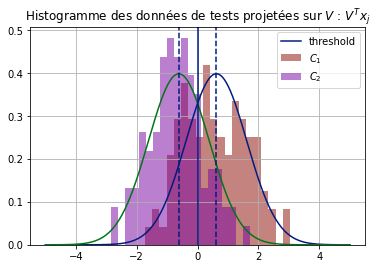

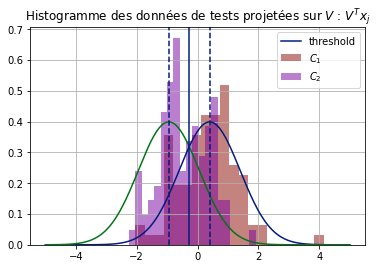

boucle = 1
0
beta = 0.8431417095169981
1
beta = 0.37256580758498636
2
beta = 0.9375228363358191
3
[[50, 50], [6, 6], [50, 50]]
n =  212
c0 :  0.4716981132075472
Epsilon 1 et 2 : 
0.19
0.53
0.36
0.36
erreur empirirque = 0.36
Epsilon 1 et 2 : 
0.35
0.2
0.275
0.275
erreur empirirque = 0.275


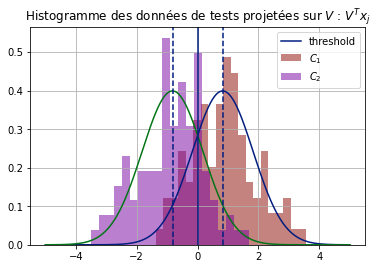

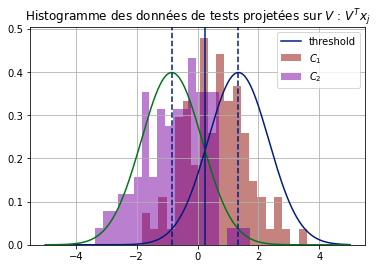

boucle = 1
0
beta = 0.8431417095169981
1
beta = 0.37256580758498636
2
beta = 0.9375228363358191
3
beta = 0.8769381202162652
4
[[50, 50], [6, 6], [50, 50], [50, 50]]
n =  312
c0 :  0.32051282051282054
Epsilon 1 et 2 : 
0.33
0.2
0.265
0.265
erreur empirirque = 0.265
Epsilon 1 et 2 : 
1.0
0.0
0.5
0.5
erreur empirirque = 0.5


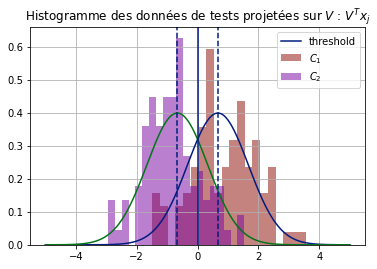

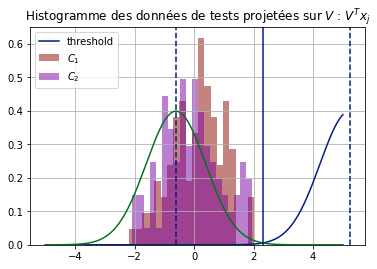

In [63]:
#%%prun -s cumulative
%matplotlib inline
# profiling
p = 100
m = 2

# t = [2**i for i in range(1,5)]
t = list(range(2,5))
n_t_test = [[100, 100]]
nt = sum(n_t_test[0])

emp_rate, th_rate, var, relative_error_rate = [], [], [], []
task_target = 1

betat = np.random.uniform(size=(t[-1]))
beta = 0
X = []
X_test = []
M = []
n_t = []
n=0
print(f"beta = {betat[task_target]}")
mean = mean_matrix(p, beta=betat[task_target], k=2)
M.append(mean[0])
M.append(mean[1])
# print(f"Verif beta = {M[-2][0][0]}, {M[-2][1][0]}, {M[-1][0][0]}, {M[-1][1][0]}")
X_test, y_test = gaussian_synthetic_data(nt, p, m, 1, n_t_test, [M[task_target]])
X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
moy = mean[1][:]
for idx,b in enumerate(t):
    M = []
    n_t = []
    n = 0
    if idx==0:
        boucle=b
    else:
        boucle = b-t[idx-1]
    print(f"boucle = {boucle}")
    first = ([[50, 50], [6,6]])
    n_t = first+[[50,50]]*(b-2)
    for i in range(b):
        print(beta)
        print(f"beta = {betat[beta]}")
        mean = mean_matrix(p, beta=betat[beta], k=1, starting=0)
        if idx==1:
            M.append(moy)
        else:
            M.append(mean[0])
        n += sum(n_t[i])
        beta+=1
    beta-=b
    err=[]
    print(b)
    print(n_t)
    print("n = ", n)
    # on crée les données synthétiques 
    c = estimate_c(n_t, n, b, m)
    c0 = p/n
    print("c0 : ",c0)
    Dc = np.diag(c)
    M_true = true_mean(M, p, b, m)
    MM_true = M_true.T@M_true
    correlation_matrix_true = compute_M_cal(n, p, Dc, MM_true, display=False)
    y_true = label_evaluation(b,m,Dc,MM_true, c0)
    m_t_true = create_mt(b, m, y_true, Dc, correlation_matrix_true, c0)
    xx = m_t_true[1][1]-m_t_true[1][0]
    rho1 = n_t[1][0]/sum(n_t[1])
    rho2 = n_t[1][1]/sum(n_t[1])
    J = create_J(m, b, n, n_t)
    for l in range(2):
        X, y_bs = gaussian_synthetic_data(n, p, m, b, n_t, M)
        MM = []
        diag = []

        for i in range(b):
            MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
#             print(f"task 1 empirical mean = {np.mean(MM1[0])}")
            MM.append(MM1)
            diag.append(diag1)

        V, y, correlation_matrix, Dc, c0 = merging_center(MM, diag, b, m, p, n, n_t, task_target, False, normalization=False) 
        X_test_aggregated = aggregate_array(X_test, p, nt, 1, m)
        X_train_aggregated = aggregate_array(X, p, nt, b, m)
#         print("c0 : ",c0)
        m_t = create_mt(b, m, y, Dc, correlation_matrix, c0)
        V_true = compute_V_old(y_true, X_train_aggregated, J)
        V_true = np.reshape(V_true, p)
        
        erreur_empirique, eps1, eps2 = compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0, 1, rho1, rho2, True, average=True)
        err.append(erreur_empirique)
#     print(MM_true)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t_true[1][0], 1))
    plt.plot(x, norm.pdf(x, m_t_true[1][1], 1))
    plt.axvline(x=1/2*(m_t_true[1][0]+m_t_true[1][1]), label='threshold')
    plt.axvline(m_t_true[1][0], ls='--')
    plt.axvline(m_t_true[1][1], ls='--')
    plt.legend()
    debug_histogram(V_true, X_test_aggregated, n_t_test)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t[1][0], 1))
    plt.plot(x, norm.pdf(x, m_t[1][1], 1))
    plt.axvline(x=1/2*(m_t[1][0]+m_t[1][1]), label='threshold')
    plt.axvline(x=m_t[1][0], ls='--')
    plt.axvline(x=m_t[1][1], ls='--')
    plt.legend()
    debug_histogram(V, X_test_aggregated, n_t_test)
#     erreur_th = error_rate(b,m, Dc, MM_true, c0, 1)[0][0]
    erreur_th = optimal_rate(xx, rho1, rho2)
    emp_rate.append(np.mean(err))
    var.append(np.std(err))
    th_rate.append(erreur_th)

%matplotlib qt
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.plot(t, emp_rate, "-o", label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

In [78]:
print(to_add)

[[50, 50], [6, 6], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50], [50, 50]]


In [29]:
%matplotlib qt
x = np.linspace(-10,10, 500)
plt.plot(x, norm.pdf(x, m_t[1][0], 1))
plt.plot(x, norm.pdf(x, m_t[1][1], 1))
debug_histogram(V, X_test_aggregated, n_t_test)
plt.show()

In [31]:
lower = np.array(emp_rate) - np.array(var)
upper = np.array(emp_rate) + np.array(var)
plt.fill_between(t, lower, upper, alpha=0.2, label="variance")
plt.plot(t, emp_rate, "-o", label='empirical rate')
plt.plot(t, th_rate, '-o', label='theoritical rate')
plt.xlabel("Nombre de tâches")
plt.ylabel("Taux d'erreur")
plt.title(r"Taux d'erreur empirique et théorique")
plt.legend()
plt.grid()
plt.show()

# Real Data

In [28]:
def normalisation(X, p, z=False):
    """
    si z: z-score normalisation par tâche
    sinon: divsion par sqrt(p)
    """
    if not z:
        for i in range(len(X)):
            for j in range(len(X[i])):
                X[i][j] *= 1/np.sqrt(p)
    else:
        for i in range(len(X)):
            task = np.concatenate((X[i][0], X[i][1]), axis=1)
            mean = np.mean(task, axis=1)
            mean = np.reshape(mean, (p, 1))
            X[i][0] = (X[i][0] - mean)/np.std(task)
            X[i][1] = (X[i][1] - mean)/np.std(task)
    return X

In [29]:
from sklearn import preprocessing

def divide_array(X,y,k,m=2):
    """
    Divide a data ndarray in an array of k arrays of m ndarrays each.
    Return the divided array and the number of elements in each classes of each tasks
    """
    X_data = []
    n_t = []
    for task in range(k):
        n_t.append([])
        X_data.append([])
        n_t1 = np.count_nonzero(y)
        n_t[task].append(n_t1)
        n_t[task].append(len(y) - n_t1)
        X_data[task].append(X[:n_t1].T)
        X_data[task].append(X[n_t1:].T)
        
    return X_data, n_t

def preprocess(X, p):
    """
    Centre et réduit les données X
    """
    tiled = np.tile(np.reshape(np.sum(X, axis=0), (p, 1)), (1, X.shape[0])).T
    X_t = np.true_divide(X, tiled, where=(tiled!=0))
    return preprocessing.scale(X, axis=0)
    

[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
(400, 999) (400, 1000)
[[999, 1000]]
[[200, 200], [50, 50]]
n :  500
lenMM : 2
0.4    0    0    0  
  0  0.4    0    0  
  0    0  0.1    0  
  0    0    0  0.1  


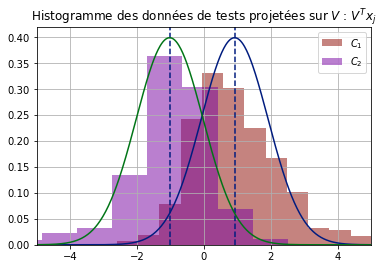

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
[[200, 200], [50, 50], [200, 200]]
n :  900
lenMM : 3
0.222222         0          0          0         0         0  
       0  0.222222          0          0         0         0  
       0         0  0.0555556          0         0         0  
       0         0          0  0.0555556         0         0  
       0         0          0          0  0.222222         0  
       0         0          0          0         0  0.222222  


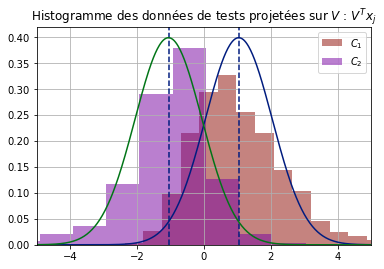

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
[[200, 200], [50, 50], [200, 200], [50, 50]]
n :  1000
lenMM : 4
0.2    0     0     0    0    0     0     0  
  0  0.2     0     0    0    0     0     0  
  0    0  0.05     0    0    0     0     0  
  0    0     0  0.05    0    0     0     0  
  0    0     0     0  0.2    0     0     0  
  0    0     0     0    0  0.2     0     0  
  0    0     0     0    0    0  0.05     0  
  0    0     0     0    0    0     0  0.05  


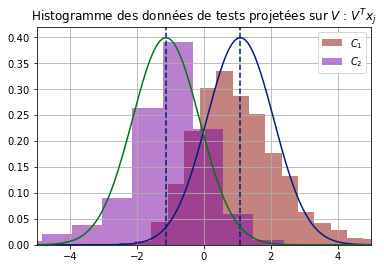

No handles with labels found to put in legend.


rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 


In [148]:
from scipy.stats import zscore
from scipy.io import loadmat

dataset = "amazon"
%matplotlib inline
m=2
p=400
n11, n12, n21, n22 = 2*100, 2*100, 50, 50
var, emp_rate, th_rate = [], [], []
if dataset == "amazon":
    k = 3
    mat = loadmat("books_400.mat")
    mat_test = loadmat("kitchen_400.mat")

    X_test_aggregated, y_test = mat_test['fts'], mat_test['labels']
    print(y_test)
    X_test_aggregated = preprocess(X_test_aggregated,p)
    X_test, n_t_test = divide_array(X_test_aggregated, y_test, 1)
    # X1 contient toute la premiere tâche
    X1_aggregated, y = mat["fts"], mat["labels"]
    X1_aggregated = preprocess(X1_aggregated, p)
#     X1_aggregated = zscore(X1_aggregated, axis=None)
    
    X, n_t = divide_array(X1_aggregated, y, 1)
    X = [[X[0][0].T[:n11].T, X[0][1].T[:n12].T]]
    n_t = [[n11, n12]]
#     X = normalisation(X, p, True)
    X.append([X_test[:][0][0].T[:n21].T, X_test[:][0][1].T[:n22].T])
#     X_test = [[X_test[0][0].T[n21:n21+500].T, X_test[0][1].T[n22:n22+50].T]]
    print(X_test[0][0].shape, X_test[0][1].shape)
    print(n_t_test)
#     n_t_test = [[500, 500]]
    n_t.append([n21, n22])
    task_target = 1
    
for t in range(2, k+2):
#     nt = sum(n_t_test[0])
    # add tasks
    if t>2:
        if t==3:
            mat = loadmat("dvd_400.mat")
            X2_aggregated, y2 = mat["fts"], mat["labels"] 
#             X2_aggregated = zscore(X2_aggregated, axis=None)
            X2_aggregated = preprocess(X2_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X2_aggregated, y2, 1)
            X_tmp = [[X_tmp[0][0].T[:n11].T, X_tmp[0][1].T[:n12].T]]
#             X_tmp = normalisation(X_tmp, p)
#             X_tmp = normalisation(X_tmp, p, True)
            X.append(X_tmp[0][:])
            n_t.append([n11, n12])
        elif t==4:
            mat = loadmat("elec_400.mat")
            X3_aggregated, y3 = mat["fts"], mat["labels"] 
#             X3_aggregated = zscore(X3_aggregated, axis=None)
            X3_aggregated = preprocess(X3_aggregated, p)
            X_tmp, n_t_tmp = divide_array(X3_aggregated, y3, 1)
            X_tmp = [[X_tmp[0][0].T[:n21].T, X_tmp[0][1].T[:n22].T]]
#             X_tmp = normalisation(X_tmp[:], p, True)
#             X_tmp = normalisation(X_tmp, p)
            X.append(X_tmp[0][:])
            n_t.append([n21, n22])
    print(n_t)
    n = sum(list(map(sum, (n_t[i] for i in range(t)))))
    print("n : ", n)
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        # chaque moyenne empirique calculée est un vecteur de taille p
#         sent+=1
#         t_MM.append(time()-t0)
        MM.append(MM1)
        diag.append(diag1)
    print(f"lenMM : {len(MM)}")
    # CENTRAL SERVER
#     t0 = time()
    # sending empirical means to central server
    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target)
    matprint(Dc)
    # END CENTRAL SERVER
#     VTX = V.T@X_test_aggregated.T
#     var.append(np.var(VTX))
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix, c0)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t[1][0], 1))
    plt.xlim(-5,5)
    plt.axvline(x=m_t[1][0],ls='--')
    plt.axvline(x=m_t[1][1],ls='--')
    plt.plot(x, norm.pdf(x, m_t[1][1], 1))
    debug_histogram(V, X_test_aggregated.T, n_t_test)
    
#     erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
    emp_rate.append(compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0))
    
%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
ticks = ["Books", "DVDs", "Electronics"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
# plt.ylim(0.18,0.24)
plt.ylabel("Empirical error rate")
plt.legend()
plt.grid()
plt.title("Real data")
plt.show()

In [47]:
print(emp_rate)

[0.2046023011505753, 0.19859929964982492, 0.1965982991495748]


# Office+Caltech Surf images

In [ ]:
p=800
n_d, n_w, n_a, n_c = 157, 295, 958, 1123
dslr = loadmat("dslr_surf_10.mat")
webcam = loadmat("webcam_surf_10.mat")
amazon = loadmat("amazon_surf_10.mat")
caltech = loadmat("caltech_surf_10.mat")
dslr_fts, y_d = dslr['feas'], dslr['label']
webcam_fts, y_w = webcam['feas'], webcam['label']
amazon_fts, y_a = amazon['feas'], amazon['label']
caltech_fts, y_c = caltech['feas'], caltech['label']

y_d = np.reshape(y_d, n_d)
y_w = np.reshape(y_w, n_w)
y_a = np.reshape(y_a, n_a)
y_c = np.reshape(y_c, n_c)

/home/sami/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


n :  212
lenMM : 2
0.471698         0          0          0  
       0  0.471698          0          0  
       0         0  0.0283019          0  
       0         0          0  0.0283019  


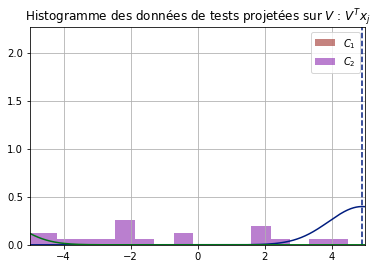

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
[0.5]


In [220]:
%matplotlib inline
n11, n12, n21, n22 = 2*100, 2*100, 50, 50
var, emp_rate, th_rate = [], [], []

n_t_test = [[6,6]]

X_test_aggregated, y_test = np.concatenate((dslr_fts[(y_d==1)][:],dslr_fts[(y_d==2)][:])), np.concatenate((y_d[:6],y_d[12:18]))
X_test_aggregated = preprocess(X_test_aggregated,p)
X_test = [
    [X_test_aggregated[:n_t_test[0][0]].T,
     X_test_aggregated[n_t_test[0][0]:].T]
]

X1_aggregated = np.concatenate((caltech_fts[(y_c==1)][:100],caltech_fts[(y_c==2)][:100]))
X = [
    [caltech_fts[(y_c==1)][:100].T, caltech_fts[(y_c==2)][:100].T],
    [dslr_fts[(y_d==1)][:6].T, dslr_fts[(y_d==2)][9:15].T]
]

n_t = [[100, 100], [6,6]]
task_target = 1

# X1_aggregated, y = mat["fts"], mat["labels"]
# X1_aggregated = preprocess(X1_aggregated, p)

# X, n_t = divide_array(X1_aggregated, y, 1)
# X = [[X[0][0].T[:n11].T, X[0][1].T[:n12].T]]
# n_t = [[n11, n12]]
# X.append([X_test[:][0][0].T[:n21].T, X_test[:][0][1].T[:n22].T])
# print(X_test[0][0].shape, X_test[0][1].shape)
# print(n_t_test)
# n_t.append([n21, n22])
t=2
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
print("n : ", n)
MM = []
diag = []

for i in range(t):
    MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
    # chaque moyenne empirique calculée est un vecteur de taille p
#         sent+=1
#         t_MM.append(time()-t0)
    MM.append(MM1)
    diag.append(diag1)
print(f"lenMM : {len(MM)}")
# CENTRAL SERVER
#     t0 = time()
# sending empirical means to central server
V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target)
matprint(Dc)
# END CENTRAL SERVER
#     VTX = V.T@X_test_aggregated.T
#     var.append(np.var(VTX))
m_t = create_mt(t, m, y_opt, Dc, correlation_matrix, c0)
x = np.linspace(-5,5, 500)
plt.plot(x, norm.pdf(x, m_t[1][0], 1))
plt.xlim(-5,5)
plt.axvline(x=m_t[1][0],ls='--')
plt.axvline(x=m_t[1][1],ls='--')
plt.plot(x, norm.pdf(x, m_t[1][1], 1))
debug_histogram(V, X_test_aggregated.T, n_t_test)

#     erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
emp_rate.append(compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0))
print(emp_rate)

In [ ]:
print(X)

In [213]:
print(X[0][0].shape)

(800, 51)


In [187]:
print(dslr_fts.shape)
for i in range(1,11):
    print(np.count_nonzero(y_w==i))

(157, 800)
151
110
100
138
85
128
133
94
87
97


# MNIST


In [72]:
pca = PCA(0.99).fit(X1)
pca.n_components_

NameError: name 'PCA' is not defined

100 composantes sont suffisantes


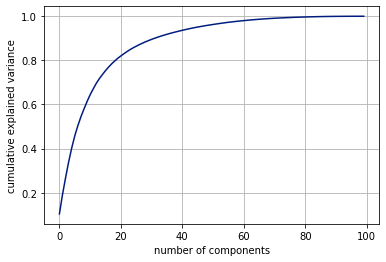

In [72]:
from sklearn.decomposition import PCA

pca = PCA().fit(X1)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

print("100 composantes sont suffisantes")

In [90]:
from keras.datasets import mnist
from sklearn.decomposition import PCA
p=100
def mnist_prepocessing(p):
    (X_train,y_train), (X_t,y_test)=mnist.load_data()
    print(X_t.shape, X_train.shape)
    X_train, X_t = np.reshape(X_train, (60000, 784)), np.reshape(X_t, (10000, 784))
    X_train, X_t = PCA(n_components=100).fit(X_train).transform(X_train), PCA(n_components=100).fit(X_t).transform(X_t)
    X_train, X_t = X_train.T, X_t.T
    print(X_t.shape, X_train.shape)
    sigma=1
#     X_train = X_train+sigma*np.random.randn(X_train.shape[0], X_train.shape[1])
#     X_t = X_t+sigma*np.random.randn(X_t.shape[0], X_t.shape[1])
    
    
    X_train /= np.max(X_train)
    X_t /= np.max(X_t)
    # mean_data=mean(data,2);mean_test=mean(test,2);
    # norm2_data=0;norm2_test=0;
    # for i=1:init_n
    #     norm2_data=norm2_data+1/init_n*norm(data(:,i)-mean_data)^2;
    # end
    # for i=1:test_n
    #     norm2_test=norm2_test+1/test_n*norm(test(:,i)-mean_test)^2;
    # end
    #  data=(data-mean_data*ones(1,size(data,2)))/sqrt(norm2_data)*sqrt(p);
    #  test=(test-mean_test*ones(1,size(test,2)))/sqrt(norm2_test)*sqrt(p);
    mean_data = np.mean(X_train,axis=1); mean_test=np.mean(X_t, axis=1)
    mean_data = np.reshape(mean_data, (p,1)); mean_test = np.reshape(mean_test, (p,1))
    norm2_data=0;norm2_test=0;
    for i in range(len(X_train)):
        norm2_data += 1/len(X_train)*np.linalg.norm(X_train.T[i]-mean_data)**2
    for i in range(len(X_t)):
        norm2_test += 1/len(X_t)*np.linalg.norm(X_t.T[i]-mean_test)**2
    X_train = (X_train-mean_data@np.ones((1, X_train.shape[1])))/np.sqrt(norm2_data)*np.sqrt(p)
    X_t = (X_t-mean_test@np.ones((1, X_t.shape[1])))/np.sqrt(norm2_test)*np.sqrt(p)
    
    return X_train, X_t, y_train, y_test
    

Using TensorFlow backend.
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sami/anaconda3/lib/python3.7/site-packages/tensorflow/py

In [91]:
X_train, X_t, y_train, y_test = mnist_prepocessing(p)
print(np.linalg.norm(X_t))

(10000, 28, 28) (60000, 28, 28)
(100, 10000) (100, 60000)
102.16655685242554


In [78]:
X0 = (X_train.T[y_train==0].T)
X1 = (X_train.T[y_train==1].T)
X2 = (X_train.T[y_train==2].T)
X3 = (X_train.T[y_train==3].T)
X4 = (X_train.T[y_train==4].T)
X5 = (X_train.T[y_train==5].T)
X6 = (X_train.T[y_train==6].T)
X7 = (X_train.T[y_train==7].T)
X8 = (X_train.T[y_train==8].T)
X9 = (X_train.T[y_train==9].T)

X0_test = (X_t.T[y_test==0].T)
X1_test = (X_t.T[y_test==1].T)
X2_test = (X_t.T[y_test==2].T)
X3_test = (X_t.T[y_test==3].T)
X4_test = (X_t.T[y_test==4].T)
X5_test = (X_t.T[y_test==5].T)
X6_test = (X_t.T[y_test==6].T)
X7_test = (X_t.T[y_test==7].T)
X8_test = (X_t.T[y_test==8].T)
X9_test = (X_t.T[y_test==9].T)

n :  100
n :  200
MM_gathered : 
   0.252167     0.12253  -0.00804478   0.0598678  
    0.12253    0.165688   -0.0199903   0.0936369  
-0.00804478  -0.0199903     0.336981  -0.0640083  
  0.0598678   0.0936369   -0.0640083    0.227597  


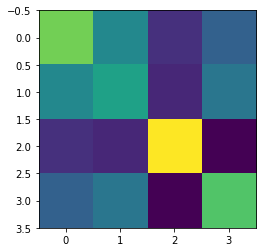

-0.0954555  
 -0.176901  
  0.670956  
 -0.494342  


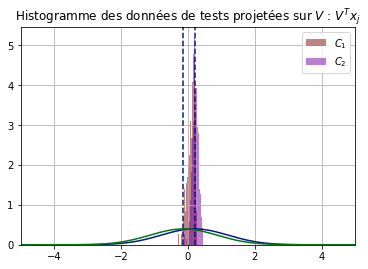

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
n :  400
MM_gathered : 
   0.252167     0.12253  -0.00804478   0.0598678   -0.0679336  -0.0624347  
    0.12253    0.165688   -0.0199903   0.0936369    -0.037568  -0.0146185  
-0.00804478  -0.0199903     0.336981  -0.0640083  -0.00918294    0.055392  
  0.0598678   0.0936369   -0.0640083    0.227597   -0.0838196  -0.0509698  
 -0.0679336   -0.037568  -0.00918294  -0.0838196     0.207546    0.036897  
 -0.0624347  -0.0146185     0.055392  -0.0509698     0.036897    0.178415  


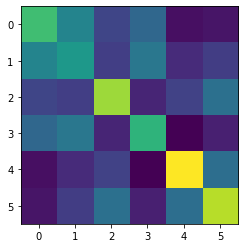

-0.163633  
-0.345693  
  1.33035  
-0.961491  
 0.199891  
 0.296235  


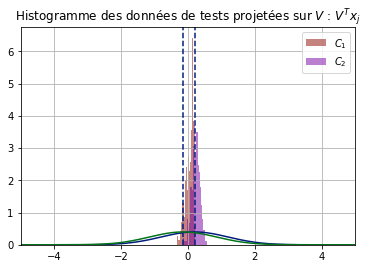

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
n :  500
MM_gathered : 
   0.252167     0.12253  -0.00804478   0.0598678   -0.0679336  -0.0624347  -0.0282839  -0.0783663  
    0.12253    0.165688   -0.0199903   0.0936369    -0.037568  -0.0146185  -0.0230881  -0.0380287  
-0.00804478  -0.0199903     0.336981  -0.0640083  -0.00918294    0.055392   0.0161986  -0.0618802  
  0.0598678   0.0936369   -0.0640083    0.227597   -0.0838196  -0.0509698  -0.0373735   0.0342224  
 -0.0679336   -0.037568  -0.00918294  -0.0838196     0.207546    0.036897   0.0488604   -0.109444  
 -0.0624347  -0.0146185     0.055392  -0.0509698     0.036897    0.178415  0.00809426  -0.0496784  
 -0.0282839  -0.0230881    0.0161986  -0.0373735    0.0488604  0.00809426   0.0962362  -0.0238647  
 -0.0783663  -0.0380287   -0.0618802   0.0342224    -0.109444  -0.0496784  -0.0238647    0.330744  


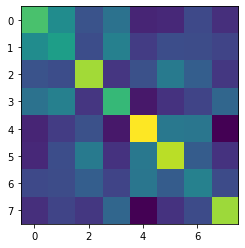

-0.214915  
-0.436283  
  1.65323  
 -1.19511  
 0.231166  
 0.363406  
 0.196481  
-0.326017  


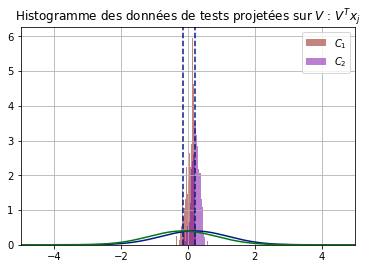

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
n :  700
MM_gathered : 
   0.252167     0.12253  -0.00804478   0.0598678   -0.0679336  -0.0624347  -0.0282839  -0.0783663   -0.0913919    0.107279  
    0.12253    0.165688   -0.0199903   0.0936369    -0.037568  -0.0146185  -0.0230881  -0.0380287   -0.0986536    0.163339  
-0.00804478  -0.0199903     0.336981  -0.0640083  -0.00918294    0.055392   0.0161986  -0.0618802  -0.00353203  -0.0299583  
  0.0598678   0.0936369   -0.0640083    0.227597   -0.0838196  -0.0509698  -0.0373735   0.0342224   -0.0103306   0.0952735  
 -0.0679336   -0.037568  -0.00918294  -0.0838196     0.207546    0.036897   0.0488604   -0.109444   0.00720573  -0.0519823  
 -0.0624347  -0.0146185     0.055392  -0.0509698     0.036897    0.178415  0.00809426  -0.0496784    0.0224849  -0.0104769  
 -0.0282839  -0.0230881    0.0161986  -0.0373735    0.0488604  0.00809426   0.0962362  -0.0238647   -0.0293831  -0.0271098  
 -0.0783663  -0

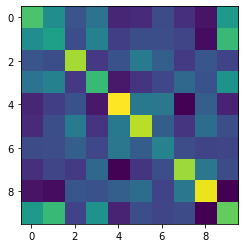

-0.253504  
-0.528298  
  2.30071  
 -1.62854  
  0.30175  
 0.507629  
 0.261814  
-0.465464  
-0.034207  
-0.606101  


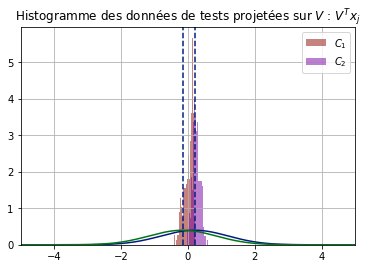

rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 
n :  800
MM_gathered : 
   0.252167     0.12253  -0.00804478   0.0598678   -0.0679336  -0.0624347  -0.0282839  -0.0783663   -0.0913919    0.107279  -0.0729536  -0.0282839  
    0.12253    0.165688   -0.0199903   0.0936369    -0.037568  -0.0146185  -0.0230881  -0.0380287   -0.0986536    0.163339  -0.0395902  -0.0230881  
-0.00804478  -0.0199903     0.336981  -0.0640083  -0.00918294    0.055392   0.0161986  -0.0618802  -0.00353203  -0.0299583  -0.0225348   0.0161986  
  0.0598678   0.0936369   -0.0640083    0.227597   -0.0838196  -0.0509698  -0.0373735   0.0342224   -0.0103306   0.0952735  -0.0967749  -0.0373735  
 -0.0679336   -0.037568  -0.00918294  -0.0838196     0.207546    0.036897   0.0488604   -0.109444   0.00720573  -0.0519823    0.253701   0.0488604  
 -0.0624347  -0.0146185     0.055392  -0.0509698     0.036897    0.178415  0.00809426  -0.0496784    0.0224849  -0.0104769   0.0396187  0.0080942

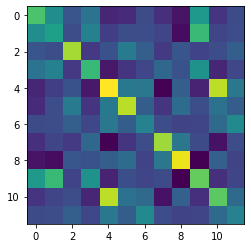

 -0.279909  
 -0.598658  
   2.63131  
  -1.84828  
  0.311253  
   0.57633  
  0.280888  
 -0.516195  
-0.0362533  
 -0.684894  
   0.28798  
  0.280888  


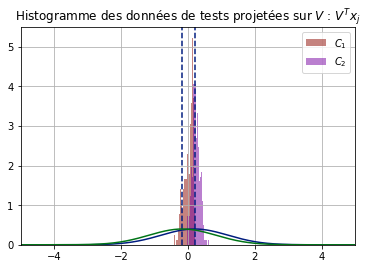

No handles with labels found to put in legend.


rho1, rho2 = 0.5, 0.5 in function
rho1, rho2 = 0.5, 0.5 in function
Epsilon 1 et 2 : 


In [80]:
%matplotlib inline
n1, n2 = 100, 50
X_test = [[X1_test.T[:250].T, X4_test.T[:250].T]]
n_t_test = [[250, 250]]
X = [[X7.T[:n2].T, X9.T[:n2].T]]
n_t = [[n2,n2]]
m, k = 2, 5
var, emp_rate = [], []
task_target = 1


n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
X_test_aggregated = aggregate_array(X_test, p, n, 1, 2)
print("n : ", n)

for t in range(2, k+2):
    # add tasks
    if t==2:
        X_tmp = [[X1.T[:n2].T, X4.T[:n2].T]]
#         X_tmp = normalisation(X_tmp,p,True)
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==3:
        X_tmp = [[X3.T[:n1].T, X8.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==4:
        X_tmp = [[X5.T[:n2].T, X6.T[:n2].T]]
        X.append(X_tmp[:][0])
        n_t.append([n2, n2])
    elif t==5:
        X_tmp = [[X2.T[:n1].T, X9.T[:n1].T]]
        X.append(X_tmp[:][0])
        n_t.append([n1, n1])
    elif t==6:
        X_tmp = [[X3.T[:n2].T, X5.T[:n2].T]]
        X.append(X_tmp[:][0])
        X.append([X3.T[:n2].T, X5.T[:n2].T])
        n_t.append([n2, n2])
    
    n = sum(list(map(sum, (n_t[i] for i in range(len(n_t))))))
    print("n : ", n)
            
    MM = []
    diag = []
    for i in range(t):
        MM1, diag1 = empirical_mean_old(1, m, [X[i]], p, [n_t[i]])
        MM.append(MM1)
        diag.append(diag1)

    V, y_opt, correlation_matrix, Dc, c0 = merging_center(MM, diag, t, m, p, n, n_t, task_target, True)
    
#     VTX = V.T@X_test_aggregated
    m_t = create_mt(t, m, y_opt, Dc, correlation_matrix, c0)
    x = np.linspace(-5,5, 500)
    plt.plot(x, norm.pdf(x, m_t[1][0], 1))
    plt.xlim(-5,5)
    plt.axvline(x=m_t[1][0],ls='--')
    plt.axvline(x=m_t[1][1],ls='--')
    plt.plot(x, norm.pdf(x, m_t[1][1], 1))
    debug_histogram(V, X_test_aggregated, n_t_test)
#     var.append(np.var(VTX))
    
    emp_rate.append(compute_error_rate(X_test, V, m_t, m, n_t_test, Dc, c0))

%matplotlib qt
plt.plot(list(range(k)), emp_rate, '-o')
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.fill_between(list(range(k)), lower, upper, alpha=0.2, label="variance")
plt.legend()
ticks = ["(7-9)", "(3-8)", "(5-6)", "(2-9)", "(3-5)"]
plt.xticks(range(len(ticks)), ticks, size='larger')
plt.xlabel("Added tasks")
plt.ylabel("Empirical error rate")
plt.grid()
plt.title("MNIST data")
plt.show()

In [178]:
print(X0.shape)

(100, 5923)


# Optimalité

In [29]:
# print((MM-MM*(np.identity(2*t)+1/sigma**2*np.identity(2*t)*MM)).shape)
from scipy.stats import norm
def bayes_risk(rho, gamma):
    """
    Compute minimal Bayes error rate of label estimation for task t
    """
    if rho==0.5:
        return 1-norm.cdf(np.sqrt(gamma))

    return 1-rho*norm.cdf(np.sqrt(gamma)-1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))-(1-rho)*norm.cdf(np.sqrt(gamma)+1/(2*np.sqrt(gamma))*np.log((1-rho)/rho))
# r1s = [1-rho1*norm.cdf(np.sqrt(q1)-np.log((1-rho1)/rho1)/(2*np.sqrt(q1)))-(1-rho1)*norm.cdf(np.sqrt(q1)+np.log((1-rho1)/rho1)/(2*np.sqrt(q1))) for q1 in q1s]

In [30]:
print(1-norm.cdf(np.sqrt(2415/1598)))
print(qfunc(np.sqrt(2415/1598)))

0.10947315012664438
0.10947315012664433


task 1 empirical mean = -0.004323420559516561
1  0  
0  1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95238095 0.5       ]
[0.9523809523809523, 0.5]
task 1 empirical mean = 0.0038719236623862485
       1  0.111111  
0.111111         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95239503 0.50295683]
[0.952395032525133, 0.5029568302779421]
task 1 empirical mean = 0.008171682497862742
       1  0.222222  
0.222222         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95243829 0.51204094]
[0.9524382901866345, 0.512040939193257]
task 1 empirical mean = -0.005908188066033056
       1  0.333333  
0.333333         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95251397 0.52793296]
[0.952513966480447, 0.5279329608938548]
task 1 empirical mean = -0.009254025322539907
       1  0.444444  
0.444444         1  
a1 = 20.0
20  0  
 0  1  
[[21.  0.]
 [ 0.  2.]]
[0.95262816 0.55191434]
[0.9526281635301752, 0.5519143413367943]
task 1 empirical mean = -0.0129617168

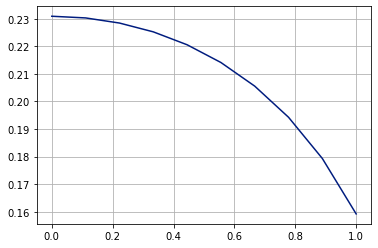

In [34]:
# T = 2, p_t = 1, lambda = 1, a1, a2 = 1 ?
# calcul de q_t
p = 100
m = 2
t = 2
beta = np.linspace(0,1,10)
n_t = [[1300, 700], [40, 60]]
n = sum(list(map(sum, (n_t[i] for i in range(t)))))
random_state=100
sigma = 1
R1, R2 = [], []
for b in beta:
    qt = []
#     M = mean_matrix(p, b, t, random_seed=random_state)
    mu = np.random.multivariate_normal(np.zeros(p),np.eye(p))#/np.sqrt(p)
    mu /= np.linalg.norm(mu)
    mu_tilde = np.random.multivariate_normal(np.zeros(p),np.eye(p))
    mu_ortho = mu_tilde - np.dot(mu,mu_tilde)*mu
    mu_ortho /= np.linalg.norm(mu_ortho)
    M = [[-mu, mu], [-(b*mu+np.sqrt(1-b**2)*mu_ortho), b*mu+np.sqrt(1-b**2)*mu_ortho]]
#     M = [[]]
    print(f"task 1 empirical mean = {np.mean(M[1][0])}")
#     (Gam@inv(I + np.diag([al1*p1*snr, al2*p2*snr])@Gam))[0,0]
    C = np.array([[1, b],[b, 1]])
#     M_true = true_mean(M, p, t, m)
#     C = M_true.T@M_true
    matprint(C)
    r1, r2 = bayes_optimal(n_t, C, p)
    R1.append(r1)
    R2.append(r2)
    
plt.plot(beta, R2)
plt.grid()
plt.show()
    

In [30]:
def bayes_optimal(n_t, MM, p, sigma=1):
    """
    Renvoie R1, R2
    """
    qt = []
    a1, a2 = (n_t[0][0]+ n_t[0][1])/p, (n_t[1][0] + n_t[1][1])/p
    print(f"a1 = {a1}")
    D = np.diag([a1/sigma**2, a2/sigma**2])
    matprint(D)
#     matprint(MM)
#     print(np.linalg.inv(np.identity(4)+D*MM))
#     print(MM*np.linalg.inv(np.identity(4)+D*MM))
    print(np.identity(2)+D*MM)
    # gros con sami
    Q = np.diag((MM-MM@np.linalg.inv(np.identity(2)+D@MM)))
    print(Q)
    qt.append(Q[0])
    qt.append(Q[1])
    
    print(qt)
    if bayes_risk(n_t[0][1]/sum(n_t[0]), qt[0])>0.5:
        R1 = (1-bayes_risk(n_t[0][0]/sum(n_t[0]), qt[0]))
    else:
        R1 = (bayes_risk(n_t[0][1]/sum(n_t[0]), qt[0]))
        
    if bayes_risk(n_t[1][1]/sum(n_t[1]), qt[1])>0.5:
        R2 = (1-bayes_risk(n_t[1][0]/sum(n_t[1]), qt[1]))
    else:
        R2 = (bayes_risk(n_t[1][1]/sum(n_t[1]), qt[1]))  
    return R1, R2

[]


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

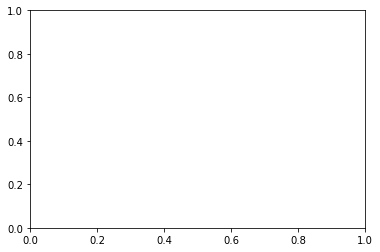

In [33]:
print(R1)
plt.plot(beta, R1, '-o', label="R1")
plt.plot(beta, R2, '-o', label="R2")
plt.legend()
plt.grid()
plt.show()

# Algorithme distribué k-tâches m classes
On se ramène à un cas 2-tâches 2-classes en fait

In [81]:
from scipy.stats import zscore

def z_normalize(X, k):
    """
    Normalise les données.
    k tâches, m classes
    X le tableau de données.
    """
    return zscore(X)

In [195]:
# Algorithme 1 du papier
k = 2
m = 10
n1 = [100 for i in range(m)]
n2 = [50 for i in range(m)]
p = 100
n_t = [n1, n2]
n_t_test = [[1000 for i in range(m)]]
nt = sum(n_t_test[0])
# faire quelque chose de généralisable
n = sum(list(map(sum, (n_t[i] for i in range(k)))))
c0 = p/n
var = []
emp_rate = []
scores = []
random_state=100
# si je peux essayer de faire plus dégeu pour le n 
M = mean_matrix(p, k=k, m=m, random_seed=random_state, random=True)
X, y_bs = gaussian_synthetic_data(n, p, m, k, n_t, M, random_state)

# choisir la tache que l'on veut tester
test_task = 1
X_test, y_test = gaussian_synthetic_data(n, p, m, 1, n_t_test, [M[test_task]], random_state)
X, X_test = z_normalize(X, k, m), z_normalize(X_test, 1, m)
# beta = []
# [[[],[]], [[], []]]

# inverser les boucles ?
for l in range(m):
    for t in range(k):
        if t==test_task:
            # how does it benefit from the other tasks?
            # pourquoi faire une boucle sur les tâches ?
    #         beta.append(l*k+t)
            X_data = []
            # on ajoute la premiere classe de la premiere tache
            X_data.append([X[t][l]])
            current_n_t = [[n_t[t][l]]]
            s = 0           

            tmp = np.empty((p, 0), float)
    #         print("tmp : ", tmp)
            for cl in range(m):
                if cl==l:
                    continue
    #             print("on ajoute : ", X[t][cl])
    #             print(X[t][cl].shape)
                tmp = np.concatenate((tmp, X[t][cl]), axis=1)
                s += n_t[t][cl]
    #         print("tmp : ", tmp)
            X_data[0].append(tmp)
    #         qui est la deuxieme tâche ? 
    #         X_data.append(X_test[0])
#             regrouper toutes les autres tâches
#             a reprendre
            temp = []
            tmp1 = np.empty((p, 0), float)
            s1 = 0
            sc = []
            for tp in range(k):
                if tp == test_task:
                    continue
                for l in range(m):
                    tmp1 = np.concatenate((tmp1, X[tp][l]), axis=1)
                    s1 += n_t[tp][l]
                temp.append(tmp1)
                sc.append(s2)
                sc.append(s1)
            X_data.append(temp)
    #         print("len(X) : ", len(X_data))
    #         print("len(X[0]) : ", len(X_data[1][0]))
            current_n_t[0].append(s)
            current_n_t.append(sc)
            print(f"current nt = {current_n_t}")
            MM = empirical_mean(2, 2, X_data, p, current_n_t)
            matprint(MM)
            c = estimate_c(current_n_t, n, 2, 2)
            Dc = np.diag(c)
            matprint(Dc)
            correlation_matrix = compute_M_cal(n, p, Dc, MM, 2, True)

            y = label_evaluation(2, 2, Dc, MM, c0)
            matprint(y)
            X_aggregated = aggregate_array(X_data, p, n, 2, 2)
            X_test_aggregated = aggregate_array(X_test, p, nt, 1, 2)

            # no need to compute V anymore
            J = create_J(2, 2, n, current_n_t)
            V = compute_V(y, X_aggregated, J, n)
            # On time le temps d'inférence

        #     debug_histogram(V_true, X_test_aggregated, n_t_test)
        #     print("V = ")
            VTX = V.T@X_test_aggregated
            var.append(np.var(VTX))
            debug_histogram(V, X_test_aggregated, n_t_test)

            # pour l'instant pas vraiment utilisé
            m_t = create_mt(2, 2, y, Dc, correlation_matrix)
            # gxt in R^1xn

            gxt = y.T@J.T@X_aggregated.T@X_test_aggregated/np.linalg.norm(y.T@J.T@X_aggregated.T)
            gxt = np.reshape(gxt, (nt))
            scores.append(gxt-m_t[0][0])

            erreur_empirique = compute_error_rate(X_test, V, m_t, 1, 2, n_t_test, Dc, c0)
    #         erreur_theorique = error_rate(t, m,  Dc, MM_true, c0)[0][0]
            emp_rate.append(erreur_empirique)
    #         th_rate.append(erreur_theorique)
    #         relative_error_rate.append(abs(erreur_empirique - erreur_theorique)/erreur_theorique)

estimated_class=[]
for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))

        
        
# lower = np.array(emp_rate) - np.array(var)
# upper = np.array(emp_rate) + np.array(var)
# plt.plot(beta, emp_rate, '-o', label='empirical rate')
# plt.fill_between(beta, lower, upper, alpha=0.2, label="variance")
# plt.legend()
# plt.title(f"2-class Gaussian mixture transfer error rate for n={n} and p={p}")
# plt.xlabel("Task relatedness (beta)")
# plt.ylabel("error rate")
# plt.grid()
# plt.show()
        

random
beta 0.5434049417909654


KeyboardInterrupt: 

In [162]:
print(X_data[1][1].shape)

(100, 1000)


In [168]:
estimated_class = []
erreur= []

for j in range(len(scores[0])):
#     print(np.argmax(scores[l][j] for l in range(m)))
    classes=[]
    for l in range(m):
#         print(scores[l][j])
        classes.append(scores[l][j])
#     print(classes)
    estimated_class.append(np.argmax(classes))
    erreur.append(int(np.argmax(classes)==y_test[j]))
    
err = erreur.count(1)/len(scores[0])
if err>0.5:
    err = 1-err

print(err)
# estimated_class
# print(np.argmax(scores[l][0] for l in range(m)))
# print(np.argmax((scores[0][0], scores[1][0])))

0.5
800


In [165]:
ones=0
twos=0
for i in range(len(scores[0])):
    maxi = scores[0][i]
    indice = 0
    for idx, score in enumerate(scores):
        if score[i] > maxi:
            maxi = score[i]
            indice = idx
    l = indice%2+1
    if l == 1:
        ones+=1
    else:
        twos+=1
    
#     print(l)
print(f"Empirical proportions : \nC1 proportion : {ones/len(scores[0])*100} %, C2 proportion : {twos/len(scores[0])*100} %")
print(f"Theoritical proportions : \nC1 proportion : {round(sum(n1)/(sum(n1)+sum(n2))*100, 3)} %, C2 proportion : {round(sum(n2)/(sum(n1)+sum(n2))*100, 3)} %")

Empirical proportions : 
C1 proportion : 0.0 %, C2 proportion : 100.0 %
Theoritical proportions : 
C1 proportion : 66.667 %, C2 proportion : 33.333 %


In [98]:
print(current_n_t)
print(gxt.shape)
print(J.T.shape)
print(X_aggregated.T.shape)
print(X_test_aggregated.shape)

[[200, 600]]
(1, 800)
(2, 800)
(800, 100)
(100, 800)


In [102]:
print(tmp.shape)
print(s)
print(len(X_data))
print(np.ones((n_t[0][0], 1)).T.shape)
print((X_data[0][0].T.shape))
print((X_data[0][1].shape))
print(np.ones(n_t[0][1]).shape)
#1x240x50
print(X_data)
print(X[3][1])
print(X[3][0])

(2, 2)
2
2
(1, 4)
(2, 2)
(2, 2)
(4,)
[[array([[-0.88007943, -0.47482649],
       [-0.96586158,  0.2590587 ]]), array([[0.92226127, 0.38656715],
       [0.91331841, 0.40724621]])], [array([[0.36683514, 0.43040179, 0.0591088 , 0.82261317],
       [0.24975802, 0.77567657, 0.21940746, 0.53647661]]), array([[-0.34926064, -0.34675433, -0.05486188, -0.8687742 ],
       [-0.1093427 , -0.39596414, -0.807452  , -0.42341213]])]]
[[-0.88007943 -0.47482649]
 [-0.96586158  0.2590587 ]]
[[0.92226127 0.38656715]
 [0.91331841 0.40724621]]


In [65]:
print(n_t[0][0])
print(X[1][0].shape)
print(X_data[0][0].shape)
print(current_n_t)

50
(200, 10)
(200, 50)
[[50, 50], [500, 500]]


In [104]:
n_t = [[10,10], [4,4], [5,5]]
n = sum(list(map(sum, (n_t[i] for i in range(2)))))
print(list(n_t[i] for i in range(3) if i!=0))
current = [n_t[0], list(n_t[i] for i in range(2) if i!=0)[0]]
current

[[4, 4], [5, 5]]


[[10, 10], [[4, 4]]]

In [1]:
import pandas

In [6]:
help(pandas.DataFrame.sum)

Help on function sum in module pandas.core.generic:

sum(self, axis=None, skipna=None, level=None, numeric_only=None, min_count=0, **kwargs)
    Return the sum of the values over the requested axis.
    
    This is equivalent to the method ``numpy.sum``.
    
    Parameters
    ----------
    axis : {index (0), columns (1)}
        Axis for the function to be applied on.
    skipna : bool, default True
        Exclude NA/null values when computing the result.
    level : int or level name, default None
        If the axis is a MultiIndex (hierarchical), count along a
        particular level, collapsing into a Series.
    numeric_only : bool, default None
        Include only float, int, boolean columns. If None, will attempt to use
        everything, then use only numeric data. Not implemented for Series.
    min_count : int, default 0
        The required number of valid values to perform the operation. If fewer than
        ``min_count`` non-NA values are present the result will b